# Problem 1: Quantum Fourier Transform

### Note: see file "optimized_qft.ipynb" for the circuit design

In [9]:
# There's a dependency in Bloqade that (currently)
# spits out some warnings you don't need to worry about.
import warnings
warnings.filterwarnings("ignore")

from bloqade.qasm2.rewrite.native_gates import RydbergGateSetRewriteRule
from kirin.rewrite import Walk
from bloqade import qasm2
from bloqade.qasm2.parse.lowering import QASM2
from bloqade.qasm2.passes import QASM2Py
from bloqade.qasm2.emit import QASM2 # the QASM2 target
from bloqade.qasm2.parse import pprint # the QASM2 pretty printer

from kirin import ir
from qiskit import QuantumCircuit

from bloqade.qasm2.rewrite.native_gates import RydbergGateSetRewriteRule
from kirin import ir
from kirin.rewrite import Walk
from bloqade.qasm2.passes import UOpToParallel, QASM2Fold

from bloqade.qasm2.emit import QASM2 # the QASM2 target
from bloqade.qasm2.parse import pprint # the QASM2 pretty printer

target = QASM2(allow_parallel=True)

import numpy as np


@ir.dialect_group(qasm2.extended)
def extended_opt(self):
    native_rewrite = Walk(RydbergGateSetRewriteRule(self)) # use Kirin's functionality to walk code line by line while applying neutral-atom gate decomposition as defined in Bloqade
    parallelize_pass = UOpToParallel(self) # review the code and apply parallelization using a heuristic
    agg_fold = QASM2Fold(self) # supports parallelization by unfolding loops to search for parallelization opportunities

    # here we define our new compiler pass
    def run_pass(
        kernel: ir.Method,
        *,
        fold: bool = True,
        typeinfer: bool = True,
        parallelize: bool = False,
    ):
        assert qasm2.extended.run_pass is not None
        qasm2.extended.run_pass(kernel, fold=fold, typeinfer=typeinfer) # apply the original run_pass to the lowered kernel
        native_rewrite.rewrite(kernel.code) # decompose all gates in the circuit to neutral atom gate set

        # here goes our parallelization optimizer; the order of the commands here matters!
        if parallelize:
            agg_fold.fixpoint(kernel)
            parallelize_pass(kernel)

    return run_pass


# helper to go from Method → Qiskit
def method_to_qiskit(method: ir.Method, *,parallelize: bool = True) -> QuantumCircuit:
    # run extended pass in case forgot
    extended_opt.run_pass(method, parallelize=parallelize)
    # emit OpenQASM2 text
    qasm = QASM2().emit_str(method)
    # parse into a Qiskit circuit
    return QuantumCircuit.from_qasm_str(qasm)

def method_to_qiskit_noparallel(method: ir.Method, *,parallelize: bool = True) -> QuantumCircuit:
    # emit OpenQASM2 text
    qasm = QASM2().emit_str(method)
    # parse into a Qiskit circuit
    return QuantumCircuit.from_qasm_str(qasm)

def print_gate_counts(ast): 
    """
    Print the counts of parallel and non parallel in the given AST,
    Distinguishing between single U and CZ gates and their parallelized versions.
    """
    test_string = qasm2.parse.spprint(ast)

    parallel_cz_count = test_string.count("parallel.CZ")
    parallel_u_count = test_string.count("parallel.U")
    u_count = test_string.count("U")  # To avoid counting "parallel.U"
    cz_count = test_string.count("cz")

    print(f"parallel CZ: {parallel_cz_count}")
    print(f"parallel U: {parallel_u_count}")
    print(f"other U: {u_count - parallel_u_count}")
    print(f"other CZ: {cz_count}")

In [10]:
from pathlib import Path

# path to wherever Jupyter is launched from
project_root = Path.cwd()  

# now build a path to .qasm files
qasm_dir   = project_root
qasm_file_paths = sorted(qasm_dir.glob("*.qasm"))


if not qasm_file_paths:
    raise FileNotFoundError(f"No .qasm files found in {qasm_dir}")
from bloqade import qasm2
from bloqade.qasm2.parse.lowering import QASM2
from bloqade.qasm2.passes import QASM2Py

# parse & lower each one
programs = {}
for path in qasm_file_paths:
    prog = QASM2(qasm2.main).loadfile(file=path)

    """
    reinterpret into Bloqade's parallelization-friendly intermediate representation. 
    Similar behaviour could have been obtained by just using qasm2.extended above
    """
    QASM2Py(prog.dialects)(prog)
    prog = prog.similar(qasm2.extended)

    programs[Path(path).stem] = prog
    print(f"→ {path} parsed & lowered: {prog}")

# `programs` now holds each file’s lowered IR under its filename-stem.


→ /home/alessandro/Desktop/qhack/EmbeddedMemes/1/qft.qasm parsed & lowered: Method("qft")
→ /home/alessandro/Desktop/qhack/EmbeddedMemes/1/qft_10.qasm parsed & lowered: Method("qft_10")
→ /home/alessandro/Desktop/qhack/EmbeddedMemes/1/qft_12.qasm parsed & lowered: Method("qft_12")
→ /home/alessandro/Desktop/qhack/EmbeddedMemes/1/qft_4.qasm parsed & lowered: Method("qft_4")
→ /home/alessandro/Desktop/qhack/EmbeddedMemes/1/qft_6.qasm parsed & lowered: Method("qft_6")
→ /home/alessandro/Desktop/qhack/EmbeddedMemes/1/qft_8.qasm parsed & lowered: Method("qft_8")
→ /home/alessandro/Desktop/qhack/EmbeddedMemes/1/qft_base_12.qasm parsed & lowered: Method("qft_base_12")
→ /home/alessandro/Desktop/qhack/EmbeddedMemes/1/qft_base_4.qasm parsed & lowered: Method("qft_base_4")
→ /home/alessandro/Desktop/qhack/EmbeddedMemes/1/qft_base_6.qasm parsed & lowered: Method("qft_base_6")
→ /home/alessandro/Desktop/qhack/EmbeddedMemes/1/qft_base_9.qasm parsed & lowered: Method("qft_base_9")


In [3]:
from bloqade.qasm2.emit import QASM2 # the QASM2 target
from bloqade.qasm2.parse import pprint # the QASM2 pretty printer

target = QASM2(allow_parallel=True)

In [34]:
filename = "qft_6"
circuit = programs[filename]
program = target.emit(circuit)
pprint(program)

KIRIN {func,lowering.call,lowering.func,py.ilist,qasm2.core,qasm2.expr,qasm2.indexing,qasm2.parallel,qasm2.uop,scf};
include "qelib1.inc";
qreg var_0[10];
h var_0[5];
CX var_0[5], var_0[8];
CX var_0[8], var_0[7];
CX var_0[7], var_0[6];
CX var_0[5], var_0[9];
CX var_0[6], var_0[0];
CX var_0[7], var_0[1];
CX var_0[8], var_0[2];
CX var_0[9], var_0[3];
CX var_0[5], var_0[4];
U(0.0, -2.356194490192345, 1.5707963267948966) var_0[4];
U(0.0, -1.9634954084936207, 1.5707963267948966) var_0[3];
U(0.0, -1.7671458676442586, 1.5707963267948966) var_0[2];
U(0.0, -1.6689710972195777, 1.5707963267948966) var_0[1];
U(0.0, -1.6198837120072371, 1.5707963267948966) var_0[0];
CX var_0[6], var_0[0];
CX var_0[7], var_0[1];
CX var_0[8], var_0[2];
CX var_0[9], var_0[3];
CX var_0[5], var_0[4];
CX var_0[5], var_0[9];
CX var_0[8], var_0[7];
CX var_0[5], var_0[8];
CX var_0[5], var_0[6];
U(0.0, -0.04908738521234057, 1.5707963267948966) var_0[5];
h var_0[4];
CX var_0[4], var_0[7];
CX var_0[7], var_0[6];
CX var_0[4], 

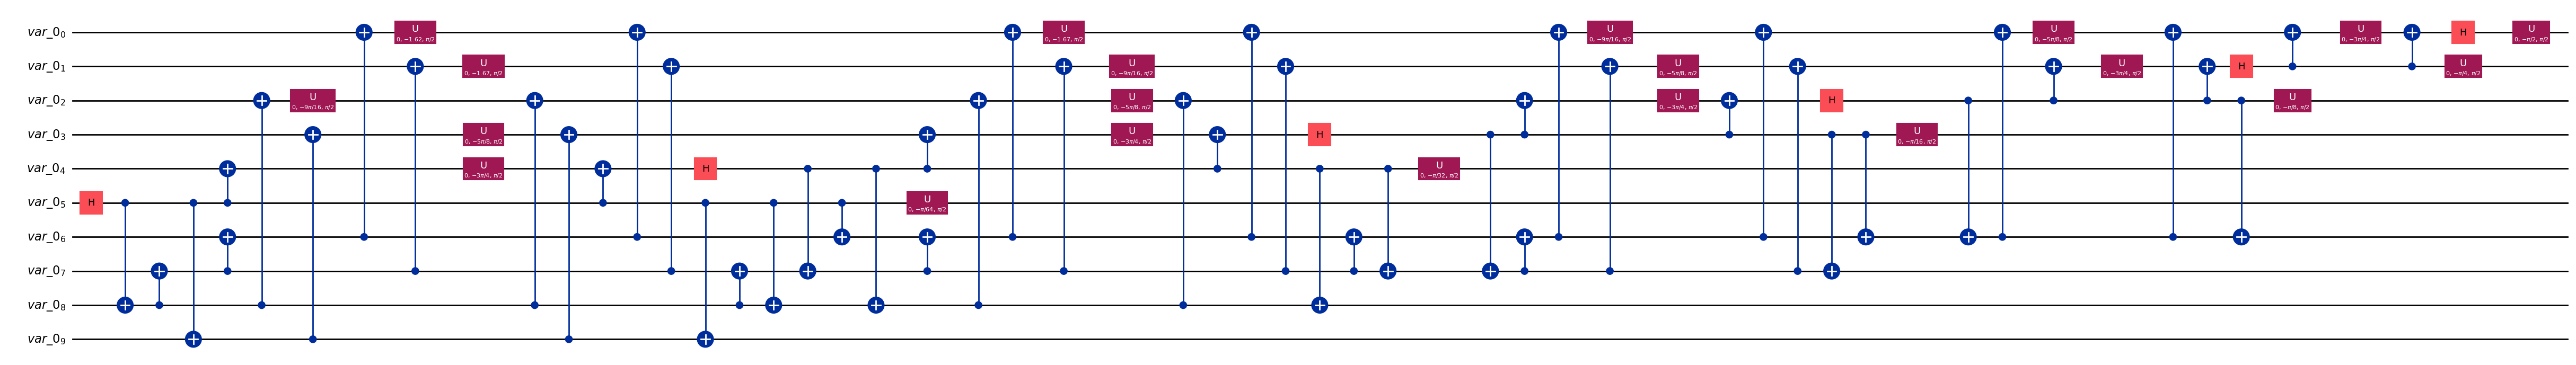

In [35]:
qc = method_to_qiskit_noparallel(circuit)
#print(qc.draw(output="text"))
fig = qc.draw(output="mpl", fold=120, scale=1)
display(fig)   # in a Jupyter notebook

## Counting parallel gates

### Optimized circuit

In [25]:
# There's a dependency in Bloqade that (currently)
# spits out some warnings you don't need to worry about.
import warnings
warnings.filterwarnings("ignore")

from bloqade.qasm2.rewrite.native_gates import RydbergGateSetRewriteRule
from kirin.rewrite import Walk

In [26]:
Walk(RydbergGateSetRewriteRule(circuit.dialects)).rewrite(circuit.code)
native_gates_unoptimized_ast = target.emit(circuit)
pprint(native_gates_unoptimized_ast)

KIRIN {func,lowering.call,lowering.func,py.ilist,qasm2.core,qasm2.expr,qasm2.indexing,qasm2.parallel,qasm2.uop,scf};
include "qelib1.inc";
qreg var_0[10];
U(1.5707963267949, 0.0, 3.14159265358979) var_0[5];
U(1.5707963267949, 0.0, 6.28318530717959) var_0[8];
cz var_0[5], var_0[8];
U(1.5707963267949, 3.14159265358979, 3.14159265358979) var_0[8];
U(0.0, 0.0, 3.14159265358979) var_0[5];
U(0.0, 0.0, 6.28318530717958) var_0[8];
U(1.5707963267949, 0.0, 6.28318530717959) var_0[7];
cz var_0[8], var_0[7];
U(1.5707963267949, 3.14159265358979, 3.14159265358979) var_0[7];
U(0.0, 0.0, 3.14159265358979) var_0[8];
U(0.0, 0.0, 6.28318530717958) var_0[7];
U(1.5707963267949, 0.0, 6.28318530717959) var_0[6];
cz var_0[7], var_0[6];
U(1.5707963267949, 3.14159265358979, 3.14159265358979) var_0[6];
U(0.0, 0.0, 3.14159265358979) var_0[7];
U(0.0, 0.0, 6.28318530717958) var_0[6];
U(1.5707963267949, 0.0, 6.28318530717959) var_0[9];
cz var_0[5], var_0[9];
U(1.5707963267949, 3.14159265358979, 3.14159265358979) var

In [27]:
from bloqade.qasm2.passes import UOpToParallel

UOpToParallel(circuit.dialects)(circuit)
parallelized_circuit = circuit.similar(qasm2.extended)

In [28]:
native_gates_optimized_ast = target.emit(parallelized_circuit)
pprint(native_gates_optimized_ast)

KIRIN {func,lowering.call,lowering.func,py.ilist,qasm2.core,qasm2.expr,qasm2.indexing,qasm2.parallel,qasm2.uop,scf};
include "qelib1.inc";
qreg var_0[10];
U(1.5707963267949, 0.0, 3.14159265358979) var_0[5];
parallel.U(1.5707963267949, 0.0, 6.28318530717959) {
  var_0[8];
  var_0[7];
  var_0[6];
  var_0[9];
  var_0[0];
  var_0[1];
  var_0[2];
  var_0[3];
  var_0[4];
}
cz var_0[5], var_0[8];
U(1.5707963267949, 3.14159265358979, 3.14159265358979) var_0[8];
U(0.0, 0.0, 3.14159265358979) var_0[5];
U(0.0, 0.0, 6.28318530717958) var_0[8];
cz var_0[8], var_0[7];
U(1.5707963267949, 3.14159265358979, 3.14159265358979) var_0[7];
U(0.0, 0.0, 3.14159265358979) var_0[8];
U(0.0, 0.0, 6.28318530717958) var_0[7];
cz var_0[7], var_0[6];
U(1.5707963267949, 3.14159265358979, 3.14159265358979) var_0[6];
U(0.0, 0.0, 3.14159265358979) var_0[7];
U(0.0, 0.0, 6.28318530717958) var_0[6];
cz var_0[5], var_0[9];
U(1.5707963267949, 3.14159265358979, 3.14159265358979) var_0[9];
U(0.0, 0.0, 3.14159265358979) var_0[5]

In [29]:
# Lets plug in the AST we got from translating the QAOA circuit 
# to the native gate set but with no optimizations

print("Unoptimized Circuit with Native Gates")
print_gate_counts(native_gates_unoptimized_ast)

print("\n")

# Now lets plug in the AST we got after parallelization

print("Optimized Circuit with Native Gates")
print_gate_counts(native_gates_optimized_ast)

Unoptimized Circuit with Native Gates
parallel CZ: 0
parallel U: 0
other U: 227
other CZ: 50


Optimized Circuit with Native Gates
parallel CZ: 5
parallel U: 22
other U: 175
other CZ: 40


### Standard circuit

In [4]:
# There's a dependency in Bloqade that (currently)
# spits out some warnings you don't need to worry about.
import warnings
warnings.filterwarnings("ignore")

from bloqade.qasm2.rewrite.native_gates import RydbergGateSetRewriteRule
from kirin.rewrite import Walk

filename = "qft_base_6"
circuit = programs[filename]
program = target.emit(circuit)

In [5]:
Walk(RydbergGateSetRewriteRule(circuit.dialects)).rewrite(circuit.code)
native_gates_unoptimized_ast = target.emit(circuit)

In [6]:
from bloqade.qasm2.passes import UOpToParallel

UOpToParallel(circuit.dialects)(circuit)
parallelized_circuit = circuit.similar(qasm2.extended)

In [7]:
native_gates_optimized_ast = target.emit(parallelized_circuit)

In [8]:
# Lets plug in the AST we got from translating the QAOA circuit 
# to the native gate set but with no optimizations

print("Unoptimized Circuit with Native Gates")
print_gate_counts(native_gates_unoptimized_ast)

print("\n")

# Now lets plug in the AST we got after parallelization

print("Optimized Circuit with Native Gates")
print_gate_counts(native_gates_optimized_ast)

Unoptimized Circuit with Native Gates
parallel CZ: 0
parallel U: 0
other U: 156
other CZ: 30


Optimized Circuit with Native Gates
parallel CZ: 0
parallel U: 0
other U: 156
other CZ: 30


## Scalability

Our qft circuit is written for generic number of qbits, making it easy to scale the dimension of the system and appreciate the great advantages of gate parallelism

### Note: this might take a while (>3 min).  Feel free to try with 10 or 8 gates instead!

In [36]:
filename = "qft_12" # choose the number of gates simply by changing the filename

circuit = programs[filename]
program = target.emit(circuit)

print("... imported the circuit")

import warnings
warnings.filterwarnings("ignore")

from bloqade.qasm2.rewrite.native_gates import RydbergGateSetRewriteRule
from kirin.rewrite import Walk
Walk(RydbergGateSetRewriteRule(circuit.dialects)).rewrite(circuit.code)
native_gates_unoptimized_ast = target.emit(circuit)
from bloqade.qasm2.passes import UOpToParallel

print("... Unoptimized Circuit with Native Gates done")

UOpToParallel(circuit.dialects)(circuit)
parallelized_circuit = circuit.similar(qasm2.extended)
native_gates_optimized_ast = target.emit(parallelized_circuit)

print("Unoptimized Circuit with Native Gates")
print_gate_counts(native_gates_unoptimized_ast)

print("\n")

# Now lets plug in the AST we got after parallelization

print("Optimized Circuit with Native Gates")
print_gate_counts(native_gates_optimized_ast)

... Unoptimized Circuit with Native Gates done
Unoptimized Circuit with Native Gates
parallel CZ: 0
parallel U: 0
other U: 1058
other CZ: 242


Optimized Circuit with Native Gates
parallel CZ: 58
parallel U: 229
other U: 485
other CZ: 105


In [ ]:
filename = "qft_base_12" # choose the number of gates simply by changing the filename

circuit = programs[filename]
program = target.emit(circuit)

print("... imported the circuit")

import warnings
warnings.filterwarnings("ignore")

from bloqade.qasm2.rewrite.native_gates import RydbergGateSetRewriteRule
from kirin.rewrite import Walk
Walk(RydbergGateSetRewriteRule(circuit.dialects)).rewrite(circuit.code)
native_gates_unoptimized_ast = target.emit(circuit)
from bloqade.qasm2.passes import UOpToParallel

print("... Unoptimized Circuit with Native Gates done")

UOpToParallel(circuit.dialects)(circuit)
parallelized_circuit = circuit.similar(qasm2.extended)
native_gates_optimized_ast = target.emit(parallelized_circuit)

print("Unoptimized Circuit with Native Gates")
print_gate_counts(native_gates_unoptimized_ast)

print("\n")

# Now lets plug in the AST we got after parallelization

print("Optimized Circuit with Native Gates")
print_gate_counts(native_gates_optimized_ast)

... imported the circuit
